In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

DATA_DIR = "../Images" 

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 7266 images belonging to 6 classes.
Found 1815 images belonging to 6 classes.


In [5]:
print(train_data.class_indices)

{'earthquake': 0, 'fire': 1, 'flood': 2, 'landslide': 3, 'normal': 4, 'smoke': 5}


In [6]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [7]:
EPOCHS = 10

history = model.fit(
    
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Epoch 1/10
228/228 [==============================] - 695s 3s/step - loss: 0.6084 - accuracy: 0.7882 - val_loss: 0.3179 - val_accuracy: 0.8887
Epoch 2/10
228/228 [==============================] - 536s 2s/step - loss: 0.3612 - accuracy: 0.8734 - val_loss: 0.3233 - val_accuracy: 0.8804
Epoch 3/10
228/228 [==============================] - 1581s 7s/step - loss: 0.3168 - accuracy: 0.8913 - val_loss: 0.3121 - val_accuracy: 0.8931
Epoch 4/10
228/228 [==============================] - 527s 2s/step - loss: 0.2905 - accuracy: 0.8953 - val_loss: 0.2642 - val_accuracy: 0.9129
Epoch 5/10
228/228 [==============================] - 17792s 78s/step - loss: 0.2662 - accuracy: 0.9077 - val_loss: 0.2664 - val_accuracy: 0.9085
Epoch 6/10
228/228 [==============================] - 7769s 34s/step - loss: 0.2390 - accuracy: 0.9136 - val_loss: 0.2440 - val_accuracy: 0.9251
Epoch 7/10
228/228 [==============================] - 539s 2s/step - loss: 0.2364 - accuracy: 0.9192 - val_loss: 0.2724 - val_accuracy: 

In [ ]:
# Unfreeze base model
base_model.trainable = True

# Freeze early layers, fine-tune last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
FINE_TUNE_EPOCHS = 5
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=FINE_TUNE_EPOCHS
)


Epoch 1/5
228/228 [==============================] - 576s 2s/step - loss: 0.4094 - accuracy: 0.8640 - val_loss: 0.2489 - val_accuracy: 0.9207
Epoch 2/5
228/228 [==============================] - 546s 2s/step - loss: 0.3217 - accuracy: 0.8876 - val_loss: 0.2635 - val_accuracy: 0.9262
Epoch 3/5
228/228 [==============================] - 562s 2s/step - loss: 0.2672 - accuracy: 0.9099 - val_loss: 0.2479 - val_accuracy: 0.9289
Epoch 4/5
228/228 [==============================] - 2232s 10s/step - loss: 0.2441 - accuracy: 0.9141 - val_loss: 0.2328 - val_accuracy: 0.9377
Epoch 5/5
228/228 [==============================] - 662s 3s/step - loss: 0.2174 - accuracy: 0.9225 - val_loss: 0.2594 - val_accuracy: 0.9245


In [9]:
loss, acc = model.evaluate(val_data)
print("Validation Accuracy after Fine-tuning:", round(acc, 4))

57/57 [==============================] - 104s 2s/step - loss: 0.2470 - accuracy: 0.9306
Validation Accuracy after Fine-tuning: 0.9306


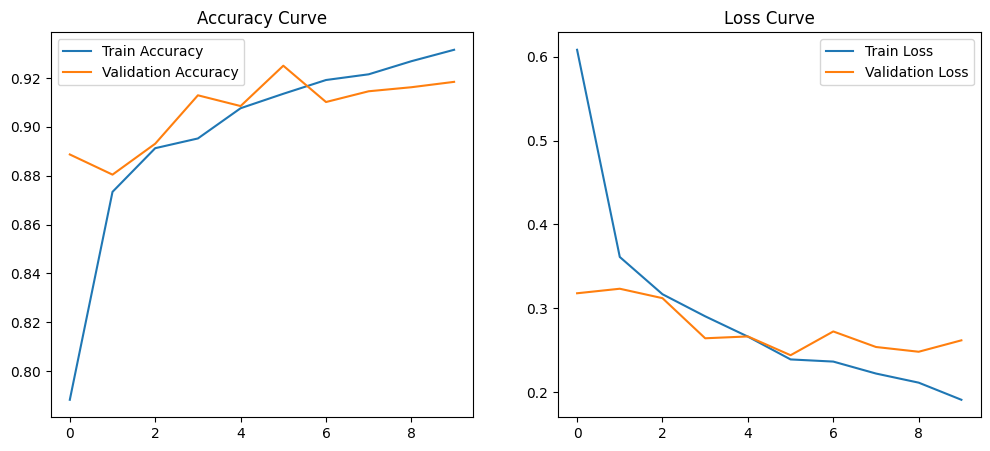

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()


57/57 [==============================] - 116s 2s/step
              precision    recall  f1-score   support

  earthquake       0.94      0.94      0.94       200
        fire       0.94      0.97      0.95       507
       flood       0.94      0.94      0.94       541
   landslide       0.87      0.77      0.82        62
      normal       0.90      0.89      0.90       445
       smoke       0.95      0.87      0.90        60

    accuracy                           0.93      1815
   macro avg       0.92      0.90      0.91      1815
weighted avg       0.93      0.93      0.93      1815



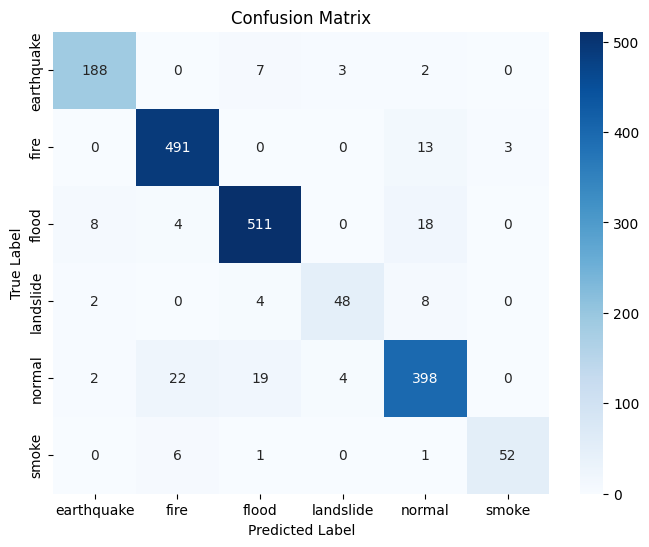

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels
val_data.reset()
Y_true = val_data.classes

# Predict
Y_pred = model.predict(val_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Classification report
print(classification_report(Y_true, Y_pred_classes, target_names=val_data.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=val_data.class_indices.keys(),
            yticklabels=val_data.class_indices.keys(),
            cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [12]:
# Get prediction probabilities
val_data.reset()
Y_probs = model.predict(val_data)

# Convert to DataFrame
import pandas as pd

prob_df = pd.DataFrame(
    Y_probs,
    columns=val_data.class_indices.keys()
)

# Add true labels
prob_df["true_label"] = Y_true

prob_df.head()


57/57 [==============================] - 86s 2s/step


,earthquake,fire,flood,landslide,normal,smoke,true_label
0,0.997099,1.020064e-07,0.002292,0.000273,0.000335,4.568673e-10,0
1,0.768010,7.514025e-07,0.000106,0.231794,0.000087,1.717589e-06,0
2,0.894466,2.770500e-04,0.000109,0.100210,0.004642,2.963850e-04,0
3,0.949701,9.225391e-06,0.007343,0.000011,0.042935,3.152351e-07,0
4,0.995426,3.761136e-05,0.001555,0.000601,0.002379,2.068380e-06,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Features = CNN probabilities (context-aware)
X = prob_df.drop("true_label", axis=1)
y = prob_df["true_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_train, y_train)

y_meta_pred = meta_model.predict(X_test)

meta_acc = accuracy_score(y_test, y_meta_pred)
print("Meta-Learner Accuracy:", meta_acc)


Meta-Learner Accuracy: 0.9173553719008265


In [16]:
cnn_accuracy = 0.90        # replace with your exact CNN-only accuracy if known
meta_accuracy = 0.9173553719008265


In [17]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": [
        "CNN Only",
        "CNN + Meta-Learner"
    ],
    "Accuracy": [
        cnn_accuracy,          # your baseline CNN accuracy
        meta_accuracy          # 0.9173...
    ]
})

comparison_df


,Model,Accuracy
0,CNN Only,0.900000
1,CNN + Meta-Learner,0.917355


In [18]:
comparison_df.to_excel("RQ2_Tab1.xlsx", index=False)


In [19]:
## RQ3: Model Explainability using Grad-CAM


import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [20]:
# img_path = val_data.filepaths[0]
img_path = r"C:\Users\Abhi Golakiya\Pictures\demo.jpg"

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

last_conv_layer = "Conv_1"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)


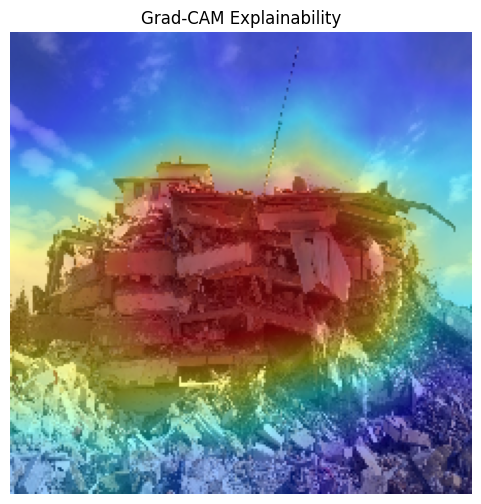

In [21]:
orig = cv2.imread(img_path)
orig = cv2.resize(orig, (224, 224))

heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

superimposed = cv2.addWeighted(orig, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Explainability")
plt.axis("off")
plt.show()


In [22]:
plt.savefig("RQ3_Fig1.pdf", bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [23]:
## RQ4: Rule-Based System Integration

def fema_rule_engine(predicted_class):
    if predicted_class == "normal":
        return "No Damage"
    elif predicted_class == "smoke":
        return "Minor Damage"
    elif predicted_class in ["fire", "flood"]:
        return "Major Damage"
    elif predicted_class in ["earthquake", "landslide"]:
        return "Destroyed"
    else:
        return "Unknown"


In [24]:
## RQ5: Real-World Testing and Failure Analysis

import pandas as pd
import numpy as np

# Reset generator
val_data.reset()

# Predict
preds = model.predict(val_data)
pred_classes = np.argmax(preds, axis=1)
true_classes = val_data.classes

# Create analysis dataframe
rq5_df = pd.DataFrame({
    "Image": val_data.filepaths,
    "True_Label": true_classes,
    "Predicted_Label": pred_classes,
    "Confidence": np.max(preds, axis=1)
})

# Keep only incorrect predictions
rq5_errors = rq5_df[rq5_df["True_Label"] != rq5_df["Predicted_Label"]]
rq5_errors.head()


57/57 [==============================] - 86s 2s/step


,Image,True_Label,Predicted_Label,Confidence
5,../Images\earthquake\earthquake\earthquake102.jpg,0,4,0.762059
6,../Images\earthquake\earthquake\earthquake103.jpg,0,3,0.645752
15,../Images\earthquake\earthquake\earthquake111.jpg,0,2,0.485167
33,../Images\earthquake\earthquake\earthquake128.jpg,0,1,0.440339
44,../Images\earthquake\earthquake\earthquake138.jpg,0,2,0.534315


In [25]:
import tensorflow as tf
import numpy as np

def predict_damage(image_path, model, class_indices):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds)
    confidence = np.max(preds)

    class_map = {v:k for k,v in class_indices.items()}
    predicted_class = class_map[pred_class_idx]

    damage_level = fema_rule_engine(predicted_class)

    return predicted_class, damage_level, confidence


In [26]:
test_image = r"C:\Users\Abhi Golakiya\Pictures\landslide2.jpg"

pred_class, damage_level, confidence = predict_damage(
    test_image,
    model,
    val_data.class_indices
)

print("Predicted Disaster Type:", pred_class)
print("Mapped Damage Level:", damage_level)
print("Confidence:", round(confidence, 3))


1/1 [==============================] - 1s 1s/step
Predicted Disaster Type: earthquake
Mapped Damage Level: Destroyed
Confidence: 0.992
